# Analisis exploratorio del dataset generado

In [1]:
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
import numpy as np
import unidecode
import re
import datetime
from datetime import datetime, timedelta, timezone

In [2]:
df = pd.read_csv('dataset.csv', index_col='id',low_memory=False)

In [3]:
df.shape

(96182, 356)

## Analisis univariado

Se utiliza la libreria pandas profiling para realizar un analisis univariado de las variables del dataset. En principio se eliminan las columnas que tienen un gran porcentaje de valores nulos

In [4]:
# Elimino las columnas que tienen mas del 50% con null
original_price = df['original_price']
df = df.loc[:, df.isnull().mean() < .5]
df['original_price'] = original_price
df.shape

(96182, 140)

In [5]:
profile = ProfileReport(df, title='ML Report', minimal=True)

profile.to_file("analisis-univariado.html")

In [6]:
#profile

Dentro de este analisis univariado se pueden encontrar la distribucion y los estadisticos principales de cada variable y asi identificar a priori las mejores para modelar.

Se pueden identificar que gran cantidad de variables que se pueden eliminar debido a la poca calidad en las mismas. Estos son los problemas principales que se encuentran:
  * Gran cantidad de nulos: Se eliminaron las columnas que tienen el mas del 60% con valores nulos. En su gran mayoria son atributos secundarios de los productos.
  * Valores constantes: Variables categoricas o numericas que no cambian de valor. Por ejemplo: accepts_mercadopago, international_delivery_mode
  * Identificadores de productos y vendedor: Los identificadores pueden generar modelos que no se comporten correctamente en un entornos reales. Por ejemplo: site_id, seller_id, category_id
  * Baja cardinalidad: Variables categoricas que la mayor cantidad de observaciones pertenecen a una sola categoria. Por ejemplo: catalog_listing

Tambien se identifican variables con alta cardinalidad y valores atipicos, para este tipo de variables se aplicaran tranformaciones para reducir esta problematica. 

## Seleccion de variables

Se seleccionan solamente las variables que tienen las mejores caracteristicas para modelar y analizar

In [7]:
variablesCuantitativas = [
    "price",
    "base_price",
    "initial_quantity",
    "available_quantity",
    "original_price",
    "sold_quantity",
    "health",
    "seller.seller_reputation.transactions.total",
    "seller.seller_reputation.transactions.canceled",
    "seller.seller_reputation.transactions.completed",
    "seller.seller_reputation.transactions.ratings.negative",
    "seller.seller_reputation.transactions.ratings.positive",
    "seller.seller_reputation.transactions.ratings.neutral",
    "seller.seller_reputation.metrics.claims.rate",
    "seller.seller_reputation.metrics.claims.value",
    "seller.seller_reputation.metrics.delayed_handling_time.rate",
    "seller.seller_reputation.metrics.delayed_handling_time.value",
    "seller.seller_reputation.metrics.sales.completed",
    "seller.seller_reputation.metrics.cancellations.rate",
    "seller.seller_reputation.metrics.cancellations.value",
    "installments.quantity",
    "installments.amount",
    "installments.rate",
]
variablesCualitativas = [
    "listing_type_id",
    "condition",
    "domain_id",
    "category_name",
    "shipping.free_shipping",
    "shipping.mode",
    "shipping.logistic_type",
    "shipping.store_pick_up",
    "address.state_name",
    "address.city_name",
    "seller.seller_reputation.power_seller_status",
    "category_settings.sub_vertical",
    "category_settings.vertical",
    "product_Marca",
    "product_Condición del ítem",
    "product_Línea",
    "sale_terms_Tipo de garantía",
]
variablesAdicionales = [
    "title",
    "warranty",
    "seller.registration_date",
    "seller.seller_reputation.metrics.delayed_handling_time.period",
    "seller.seller_reputation.metrics.sales.period",
    "seller.seller_reputation.metrics.cancellations.period",
    "seller.seller_reputation.level_id",
    "sale_terms_Tiempo de garantía",
    'date_created',
    'last_updated'
] # Variables que hay que hacerles algun tipo de preprocesamiento

todasLasVariables = variablesCuantitativas + variablesCualitativas + variablesAdicionales

In [8]:
df = df[todasLasVariables]

# Data cleaning

En esta seccion se realizan las siguientes transformaciones:

* Las variables de tipo periodo y de garantia del producto se normalizan y se pasan todas a dias
* Variables de tipo fecha, se calcula la diferencia con respecto a la fecha actual.
* Variable level, corresponde al nivel del vendedor. Originalmente es un campo de tipo string pero se convierte a un numero entre 1 y 5

In [9]:
# Se corrigen las variables de tipo periodo
print(df['seller.seller_reputation.metrics.sales.period'].value_counts())

df['seller.seller_reputation.metrics.delayed_handling_time.period'] =   pd.to_numeric(df['seller.seller_reputation.metrics.delayed_handling_time.period'].map({
    '60 days': 60, '365 days': 365,'60 months': 60*12}))

df['seller.seller_reputation.metrics.sales.period'] = pd.to_numeric( df['seller.seller_reputation.metrics.sales.period'].map({
    '60 days': 60, '365 days': 365,'60 months': 60*12}))

df['seller.seller_reputation.metrics.cancellations.period'] =  pd.to_numeric(df['seller.seller_reputation.metrics.cancellations.period'].map({
    '60 days': 60, '365 days': 365,'60 months': 60*12}))

60 days      56144
365 days     30549
60 months     6695
Name: seller.seller_reputation.metrics.sales.period, dtype: int64


In [10]:
# Acomodo la variable de garantia
def calcularMesesGarantia(campo):
    if pd.isnull(campo):
        return np.nan
    campo = unidecode.unidecode(campo.lower())
    if "sin garant" in campo:
        return 0
    
    dias = re.search('(\d+) dias', campo)
    if dias:
        return int(dias.group(1))

    
    meses = re.search('(\d+) meses', campo)
    if meses:
        return int(meses.group(1)) * 30

    año = re.search('(\d+) ano', campo)
    if año:
        return int(año.group(1)) * 30 * 12
    return np.nan

df['dias_garantia'] = df['warranty'].apply(calcularMesesGarantia)
df['dias_garantia_otro'] = df['sale_terms_Tiempo de garantía'].apply(calcularMesesGarantia)

In [11]:
# Calculo la distancia en dias para los campos de tipo fecha
df['date_created'] = pd.to_datetime(df['date_created'],utc=True)
df['last_updated'] = pd.to_datetime(df['last_updated'],utc=True)
df['seller.registration_date'] = pd.to_datetime(df['seller.registration_date'],utc=True)

In [12]:
# Calculo las variables con la diferencia en dias
df['antiguedad_vendedor'] = (pd.to_datetime("now",utc=True) - df['seller.registration_date']).dt.days
df['antiguedad_publicacion'] = (pd.to_datetime("now",utc=True) - df['date_created']).dt.days
df['antiguedad_actualizacion_publicacion'] = (pd.to_datetime("now",utc=True) - df['last_updated']).dt.days

In [13]:
#    "seller.seller_reputation.level_id",
df['seller.seller_reputation.level_id'] = df['seller.seller_reputation.level_id'].str.extract('(\d+)')

In [14]:
df.drop(['title','warranty','seller.registration_date','sale_terms_Tiempo de garantía','date_created','last_updated'],inplace=True, axis=1)

In [15]:
df['flag_descuento'] = pd.notnull(df.original_price)
df['monto descuento'] = df.original_price - df.price
df['porcentaje descuento'] = df['monto descuento'] / df.original_price * 100

In [16]:
df.head()

,price,base_price,initial_quantity,available_quantity,original_price,sold_quantity,health,seller.seller_reputation.transactions.total,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.completed,...,seller.seller_reputation.metrics.cancellations.period,seller.seller_reputation.level_id,dias_garantia,dias_garantia_otro,antiguedad_vendedor,antiguedad_publicacion,antiguedad_actualizacion_publicacion,flag_descuento,monto descuento,porcentaje descuento
id,,,,,,,,,,,,,,,,,,,,,
MLA883365318,59200.0,59200.0,17,10,NaN,7,NaN,10679.0,520.0,10159.0,...,60.0,5,30.0,30.0,3279.0,110,4,False,NaN,NaN
MLA898926425,61999.0,61999.0,128,61,NaN,67,NaN,19798.0,1099.0,18699.0,...,60.0,5,360.0,360.0,1071.0,62,3,False,NaN,NaN
MLA896793334,3711.0,3711.0,2347,943,NaN,1404,NaN,161983.0,11754.0,150229.0,...,60.0,5,360.0,360.0,3158.0,77,3,False,NaN,NaN
MLA884683677,62999.0,62999.0,1208,500,NaN,500,1.0,205987.0,8993.0,196994.0,...,60.0,5,360.0,360.0,199.0,99,3,False,NaN,NaN
MLA878643073,62999.0,62999.0,153,1,NaN,100,1.0,205987.0,8993.0,196994.0,...,60.0,5,360.0,360.0,199.0,136,3,False,NaN,NaN


# Variables mas correlacionadas con el target

In [17]:
aux = df.corr()

pd.DataFrame(pd.concat([aux['sold_quantity'].sort_values().head(10),aux['sold_quantity'].sort_values(ascending=False).head(10)])).sort_values(by='sold_quantity')

,sold_quantity
seller.seller_reputation.metrics.delayed_handling_time.period,-0.103487
seller.seller_reputation.metrics.sales.period,-0.103487
seller.seller_reputation.metrics.cancellations.period,-0.103481
original_price,-0.081659
installments.amount,-0.070069
monto descuento,-0.059539
antiguedad_actualizacion_publicacion,-0.045785
seller.seller_reputation.transactions.ratings.neutral,-0.031827
shipping.free_shipping,-0.029766
seller.seller_reputation.metrics.cancellations.rate,-0.013036


# Grafico de correlacion

<AxesSubplot:>

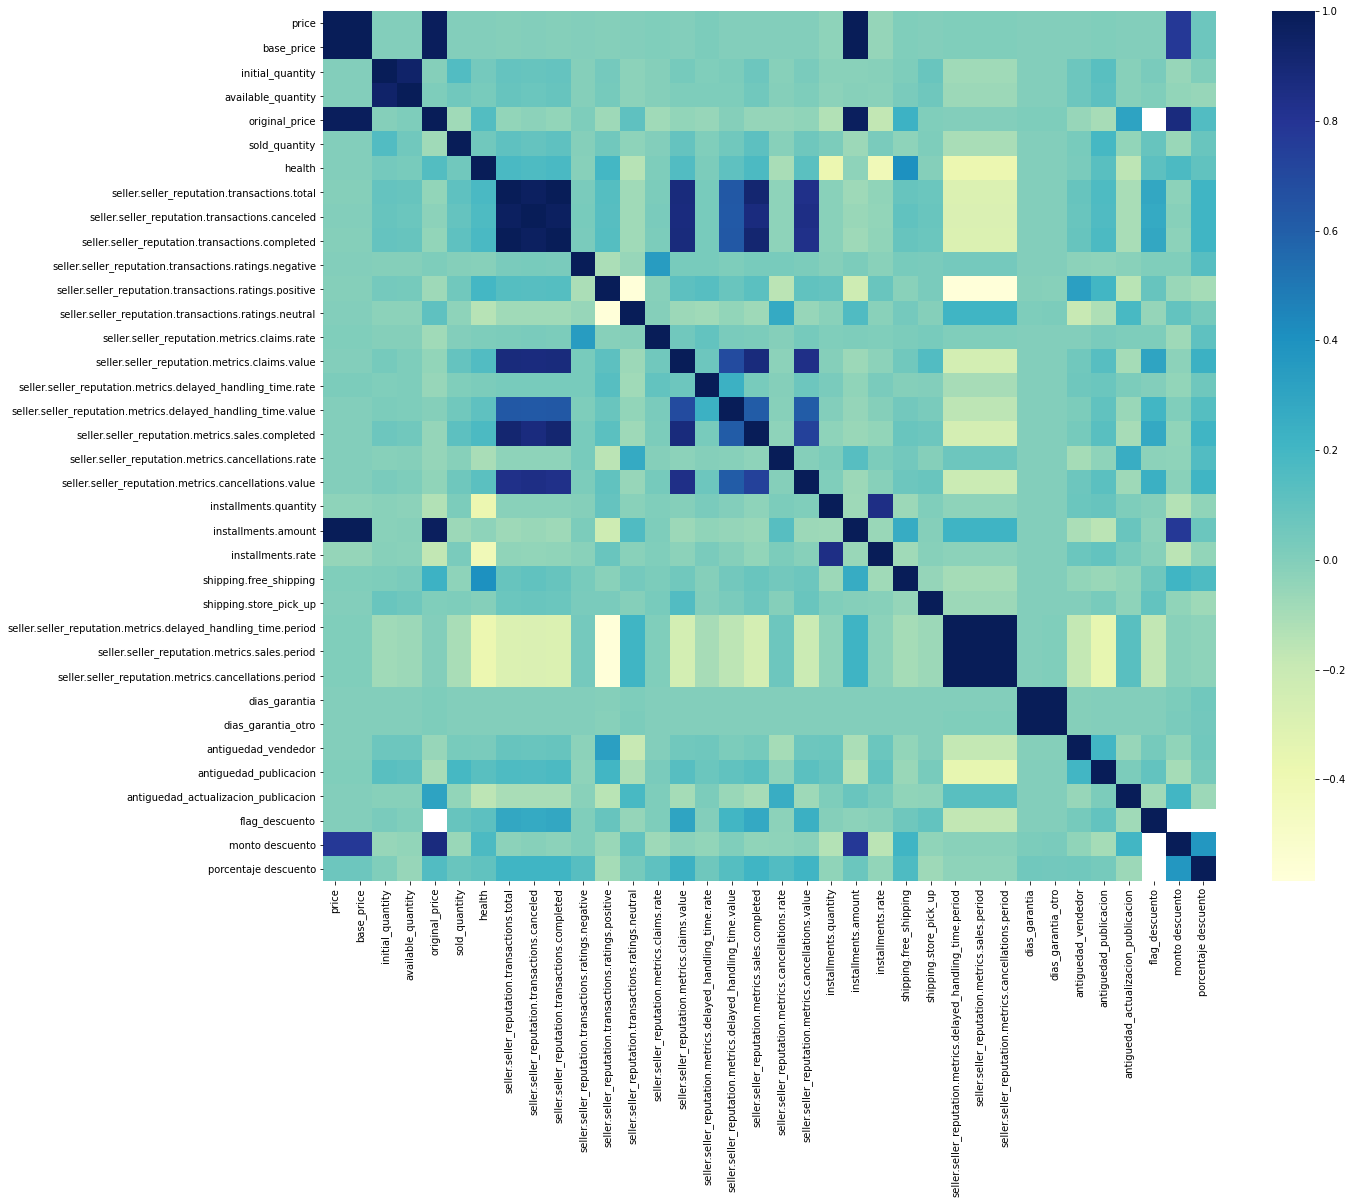

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), cmap="YlGnBu")

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sold_quantity'>

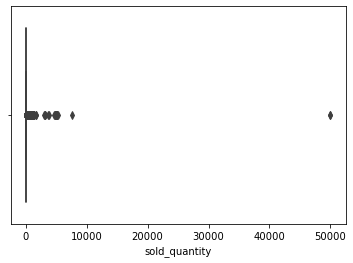

In [19]:
sns.boxplot('sold_quantity',data=df)

In [20]:
df.sold_quantity.describe()

count    96182.000000
mean        41.203760
std        292.609067
min          0.000000
25%          0.000000
50%          0.000000
75%          5.000000
max      50000.000000
Name: sold_quantity, dtype: float64

En este grafico como en la tabla anterior se puede ver que el el target(sold_quantity) tiene una muy baja correlacion lineal con respecto al resto de las variables. 

Tambien se puede identificar que la distribucion del la misma tiene un fuerte sesgo positivo, el 75% de los productos descargados tendran menos de 5 unidades vendidas. Esta situaciones generara dificiltades en el desarrollo de un modelo de regresion pero se exploraran estrategias para remediar esta situacion.

In [21]:
df.to_csv("dataset_clean.csv")